In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.cm as cm
import scipy.stats
from matplotlib import pyplot as plt 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

# prevent tensorflow from allocating the entire GPU memory at once
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

# Subclassing for Crowdlayer Rodriguez

In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_CrowdL(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=70,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=0):
        #print('init')
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K

    
 
    def custom_CLR_loss(self, y_true, y_pred): #ytrue \in N x R,  ypred \in N x K x R  ->CrowdLayerRodriguez
        #print(y_true.shape)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1) #samples, classes 1-K, annotators
        #print(Y_true_1K.shape)    
        vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=Y_true_1K, axis = 1)
        #print(vec.shape)
        mask = tf.equal(Y_true_1K[:,0,:], -1)
        zer = tf.zeros_like(vec)
        loss = tf.where(mask, x=zer, y=vec)
        #tf.print("loss", loss)
        return tf.math.reduce_sum(loss)

 
    def fit(self, X, Y):
      
        def scheduler1(step = 10, ratio = 1.2):
          def scheduler(epoch, lr):
            if epoch % step == 0 and epoch>1:
              return lr/ratio
            else:
              return lr
          return scheduler
        
        initializer = tf.keras.initializers.GlorotNormal(seed=100)
        
        P = X.shape[1]
        
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer
         
     # Block 1
        input_l = tf.keras.layers.Input(shape=(32, 32, 3), name='entrada')
        x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu",  name="block1_conv1")(input_l)   #bias_initializer='zeros', kernel_initializer=initializer
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
       # x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)


        # Block 2
        x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu",  name="block2_conv1")(x) #bias_initializer='zeros', kernel_initializer=initializer,
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2),  name="block2_pool")(x)

        # Block 3
        x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu",  name="block3_conv1" )(x)  #bias_initializer='zeros', kernel_initializer=initializer,           
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        #x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)
        
        # Block 4
        x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu",  name="block4_conv1")(x)       #bias_initializer='zeros', kernel_initializer=initializer,     
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)
        
         
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        output_dense = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(x)
        output= CrowdsClassification(self.K, self.R, conn_type="MW")(output_dense) #Classes x Annotators
       
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss= self.custom_CLR_loss, optimizer=opt)
        
        callback1 = tf.keras.callbacks.TerminateOnNaN()
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
        #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
        callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split, #callbacks = [callback1, callback2],   #
                                      batch_size=self.batch_size,verbose=self.verbose)
         
        #model_p  to predict labels in gridsearch  
        self.model_p = tf.keras.Model(inputs=self.model.inputs,outputs=self.model.get_layer('output').output) #se accede a capas por nombre
        #resumen y gráfica del modelo
        #print(self.model.summary())
        
        return self

    def predict2(self, X, *_):
      return  self.model_p.predict(X) 
     
    def predict(self, X, *_):

       #print('predict') 
       return  self.model.predict(X) 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        #print('set_params') 
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        #print('get_params') 
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K
                }

In [3]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score,  roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

def one_hot(target, n_classes):
    targets = np.array([target]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return one_hot_targets



def evaluation_metrics(y_true, y_pred, print_result=True):
    acc = 0
    auc = 0
    auc_sk = 0
    #mi = 0
    nmi = 0
    #ami = 0
    bacc = 0
    
    # Accuracy
    #report = classification_report(y_pred.argmax(axis=1), y_true.ravel(), output_dict=True)
    acc = accuracy_score( y_true.ravel(), y_pred.argmax(axis=1))  #report['accuracy']
    
    # Balanced accuracy
    bacc = balanced_accuracy_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze(), adjusted=True)
    
   # # Mutual Information
   # mi = mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Adjusted Mutual Information
    #ami = adjusted_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # AUC (Tensorflow)
    auc_metric = tf.keras.metrics.AUC(from_logits=True)
    auc_metric.update_state(y_true, y_pred.argmax(axis=1).astype('float'))
    auc = auc_metric.result().numpy()
    auc_metric.reset_states()
    
    # AUC (scikit-learn)
    auc_sk = roc_auc_score(one_hot(y_true,10), y_pred)
    
    if print_result:
        print("Accuracy: {:.4f}".format(acc))
        print("Balanced Accuracy: {:.4f}".format(bacc))
        #print("Mutual Information: {:.4f}".format(mi))
        print("Normalized Mutual Information: {:.4f}".format(nmi))
       # print("Adjusted Mutual Information: {:.4f}".format(ami))
        print("AUC (Tensorflow): {:.4f}".format(auc))
        print("AUC (scikit-learn): {:.4f}".format(auc_sk))
    
    return acc, auc, auc_sk, nmi, bacc   # mi, , ami



# Crowdlayer class

In [4]:
import matplotlib.pyplot as plt
 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K1
from tensorflow.keras.layers import Layer
#from tensorflow.keras.engine.topology import Layer

def init_identities(shape, dtype=None):
    out = np.zeros(shape)
    for r in range(shape[2]):
        for i in range(shape[0]):
            out[i,i,r] = 1.0
    return out
    
class CrowdsClassification(Layer):


  
  #The build() method’s role is to create the layer’s variables, by calling the 
  #add_weight() method for each weight.  which is often necessary to create some of the weights.
  #we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel"): 
  #this corresponds to the size of the last dimension of the inputs. 
   
    def __init__(self, output_dim, num_annotators, conn_type="MW", **kwargs):
        self.output_dim = output_dim
        self.num_annotators = num_annotators
        self.conn_type = conn_type
        super(CrowdsClassification, self).__init__(**kwargs)



    def build(self, input_shape):
        if self.conn_type == "MW":
            # matrix of weights per annotator
      #A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors. 
      #It involves computation, defined in the call() method, and a state (weight variables). 
      #the method add_weight() offers a shortcut to create weights.

            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.output_dim, self.num_annotators),
                                            initializer=init_identities, #It is the stated initializer instance
                                            trainable=True) # trainable weights, updated via backpropagation during training
        elif self.conn_type == "VW":
            # vector of weights (one scale per class) per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(), 
                                            trainable=True)
        elif self.conn_type == "VB":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "VW+B":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True))
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "SW":
            # single weight value per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.num_annotators,1),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True)
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!")
    #At the end of the build() method (and only at the end), 
    #you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built = True).
        super(CrowdsClassification, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
    
    #The call() method actually performs the desired operations. In this case, 
    #we compute the matrix multiplication of the inputs X and the layer’s kernel and 
    #this gives us the output of the layer.
     
 

        if self.conn_type == "MW":
            res = K1.dot(x, self.kernel)
        elif self.conn_type == "VW" or self.conn_type == "VB" or self.conn_type == "VW+B" or self.conn_type == "SW":
            out = []
            for r in range(self.num_annotators):
                if self.conn_type == "VW":
                    out.append(x * self.kernel[:,r])
                elif self.conn_type == "VB":
                    out.append(x + self.kernel[0][:,r])
                elif self.conn_type == "VW+B":
                    out.append(x * self.kernel[0][:,r] + self.kernel[1][:,r])
                elif self.conn_type == "SW":
                    out.append(x * self.kernel[r,0])
            res = tf.stack(out)
            if len(res.shape) == 3:
                res = tf.transpose(res, [1, 2, 0])
            elif len(res.shape) == 4:
                res = tf.transpose(res, [1, 2, 3, 0])
            else:
                raise Exception("Wrong number of dimensions for output")
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!") 
        
        return res
 
#The compute_output_shape() method simply returns the shape of this layer’s outputs. 
#In this case, it is the same shape as the inputs, except the last two dimensions is replaced 
#with the number of clases and # annotators in the layer.  
 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim, self.num_annotators)
    
class MaskedMultiCrossEntropy(object):

    def loss(self, y_true, y_pred):
        #tf.print(y_true.shape)
        #tf.print(y_pred.shape)
        vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, axis = 1)
        mask = tf.equal(y_true[:,0,:], -1)
        zer = tf.zeros_like(vec)
        loss = tf.where(mask, x=zer, y=vec)
        return loss



# Cifar-10H dataset for multiple annotators

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import cv2
import os
import time
import sys
import pickle

In [6]:
#cargar datos desde drive acceso libre 
FILEID = "1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Cifar-10H.zip && rm -rf /tmp/cookies.txt
!unzip -o Cifar-10H.zip
!dir

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-02-15 16:56:54--  https://docs.google.com/uc?export=download&confirm=t&id=1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L
Resolving docs.google.com (docs.google.com)... 173.194.211.101, 173.194.211.113, 173.194.211.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.211.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r1i95a1d14mc4lik4hhp1j9d04rquin7/1676480175000/07591141114418430227/*/1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L?e=download&uuid=ba009bef-573f-43e3-91d8-6d8fa4d2838c [following]
--2023-02-15 16:56:55--  https://doc-08-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r1i95a1d14mc4lik4hhp1j9d04rquin7/1676480175000/07591141114418430227/*/1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L?e=download&uuid=ba009bef-573f-43e3-91d8-6d8fa4d2838c
Res

## Training data

In [7]:
Data_dir = '/kaggle/working/Cifar-10H/test_batch'
labels_dir = '/kaggle/working/Cifar-10H/Answers_Processed.csv'

In [8]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [9]:
def arr_to_im(X):
  N = X.shape[0]
  X_tr = np.zeros((N,32,32,3))
  for i,x in enumerate(X):
    aux = x.reshape(3,32,32)/255
    aux = aux.transpose(1,2,0)
    X_tr[i,:] = cv2.resize(aux, (32,32))
  return X_tr

In [10]:
X = unpickle(Data_dir)[b'data']
Label = pd.read_csv(labels_dir, header=None)
Label = Label.to_numpy()
Y = Label[:,:-1]
y = Label[:,-1][:,np.newaxis]
N, R = Y.shape
K = len(np.unique(y))
# y = Label[:,np.newaxis]

In [11]:
# Se eliminan las muestras que no fueron etiquetadas por ningun anotador
idx_ = np.sum(Y,axis=1) != R*(-999)
X = X[idx_,:]
Y = Y[idx_,:]
N, R = Y.shape
y = y[idx_,:]
X = arr_to_im(X)

In [12]:
Y[Y == -999] = -1


## Test data

In [13]:
Test_dir = '/kaggle/working/Cifar-10H/data_batch_1'

In [14]:
X_te = unpickle(Test_dir)[b'data']
X_te = arr_to_im(X_te)
y_te = np.array(unpickle(Test_dir)[b'labels'])[:,np.newaxis]

In [15]:
def one_hot(target, n_classes):
    targets = np.array([target]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return one_hot_targets

In [16]:
N_CLASSES = len(np.unique(y_te))
N_ANNOT = Y.shape[1]
#Y_true_test = y_te
#print ("\nConverting to one-hot encoding...")
#Y_true_train = one_hot(Y_true_train, N_CLASSES)
#print (Y_true_train.shape)
# Y_train = one_hot(Y_train.astype('int'), N_CLASSES)
# print (Y_train.shape)
#labels_train_ds_bin = one_hot(labels_train_ds, N_CLASSES)
#print (labels_train_ds_bin.shape)
Y_true_test = one_hot(y_te, N_CLASSES)
print (Y_true_test.shape)

Y = Y.astype('int')
answers_bin_missings = []
for i in range(Y.shape[0] ):
    row = []
    for r in range(N_ANNOT):
        if Y[i,r] == -1:
            row.append(-1 * np.ones(N_CLASSES))
        else:
            row.append(one_hot(Y[i,r], N_CLASSES)[0,:])
    answers_bin_missings.append(row)
answers_bin_missings = np.array(answers_bin_missings).swapaxes(1,2)
answers_bin_missings.shape

(10000, 10)


(9233, 10, 137)

In [17]:
def eval_model(model, test_data, test_labels):
    # testset accuracy
    preds_test = model.predict(test_data)
    preds_test_num = np.argmax(preds_test, axis=1)
    accuracy_test = 1.0*np.sum(preds_test_num == test_labels) / len(test_labels)

    return accuracy_test

In [18]:
def build_base_model():
    base_model = Sequential()
    base_model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.25))
    
  

    base_model.add(Conv2D(64, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.5))
    
    base_model.add(Conv2D(128, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(128, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
#     base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.5))

    base_model.add(Flatten()) 
    base_model.add(Dense(512))
    base_model.add(Activation('relu'))
    base_model.add(Dropout(0.5))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation('softmax'))
    base_model.compile(optimizer='adam', loss='categorical_crossentropy')

    return base_model

In [19]:
def create_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=100)
    l1_param = 1e-3
    num_filters2=32
    model = Sequential()

    model.add(Conv2D(num_filters2, (3, 3), input_shape=(32,32,3), activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block1_conv1") )
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Conv2D(num_filters2, (3, 3),  activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block1_conv2"))
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(2*num_filters2,(3, 3), activation="relu",  #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block2_conv1") )
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Conv2D(2*num_filters2, (3, 3),  activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block2_conv2") )
    model.add(BatchNormalization())
   # model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(4*num_filters2,(3, 3), activation="relu",  #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block3_conv1") )
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Conv2D(4*num_filters2, (3, 3),  activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param), name="block3_conv2") )
    model.add(BatchNormalization())
   # model.add(Activation('relu'))
   # model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(512,  activation="relu", #bias_initializer='zeros', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_param, l2= l1_param)) )
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm = 1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    


    return model

Validation AUC: 0.8054
Validation aUc_Sklearn: 0.8812
Validation ACC: 0.5843
Validation Balanced_ACC: 0.5401
Validation MI: 0.9610
Validation Normalized MI: 0.4295
Validation Adjusted MI: 0.4285
Validation AUC: 0.8572
Validation aUc_Sklearn: 0.8952
Validation ACC: 0.6199
Validation Balanced_ACC: 0.5794
Validation MI: 0.9990
Validation Normalized MI: 0.4371
Validation Adjusted MI: 0.4361
Validation AUC: 0.7835
Validation aUc_Sklearn: 0.8981
Validation ACC: 0.6044
Validation Balanced_ACC: 0.5619
Validation MI: 1.0028
Validation Normalized MI: 0.4439
Validation Adjusted MI: 0.4429
Validation AUC: 0.7661
Validation aUc_Sklearn: 0.9001
Validation ACC: 0.6177
Validation Balanced_ACC: 0.5773
Validation MI: 1.0003
Validation Normalized MI: 0.4379
Validation Adjusted MI: 0.4369
Validation AUC: 0.8251
Validation aUc_Sklearn: 0.8995
Validation ACC: 0.6080
Validation Balanced_ACC: 0.5641
Validation MI: 0.9626
Validation Normalized MI: 0.4217
Validation Adjusted MI: 0.4207
Validation AUC: 0.7626
Va

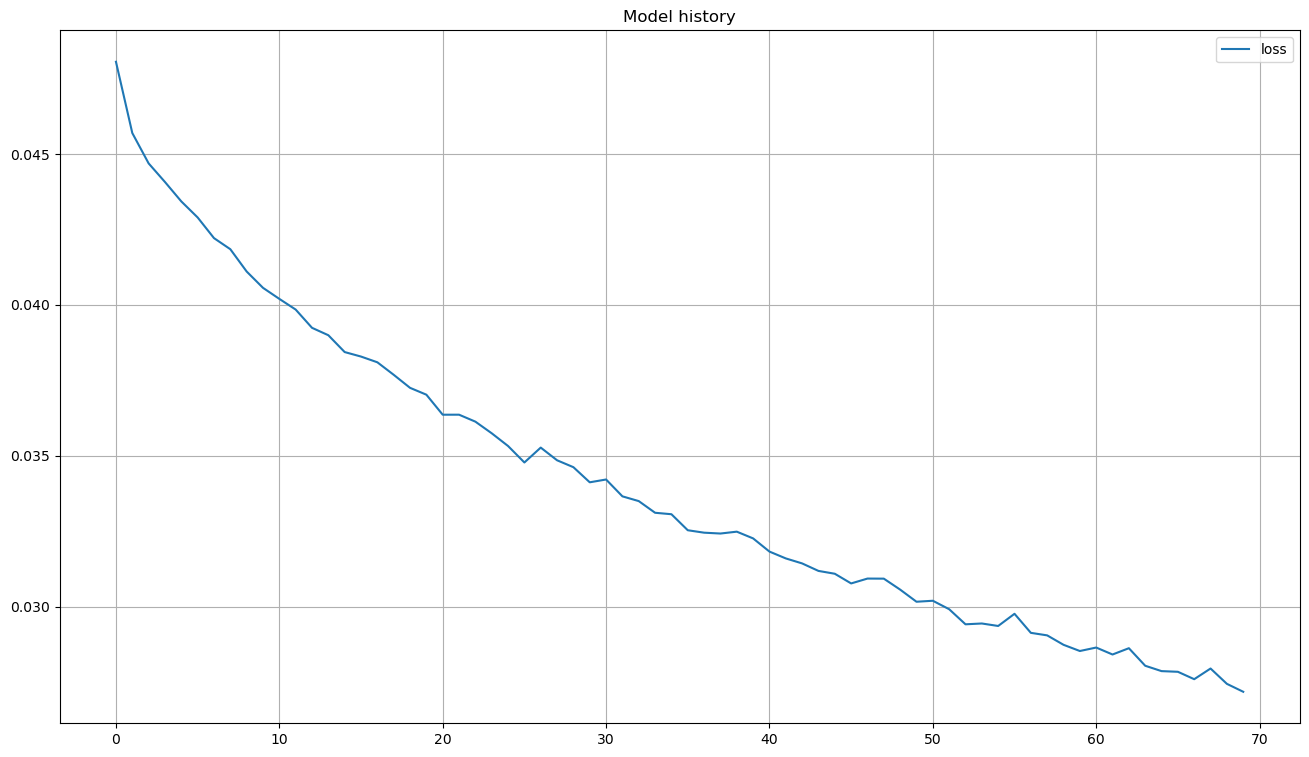

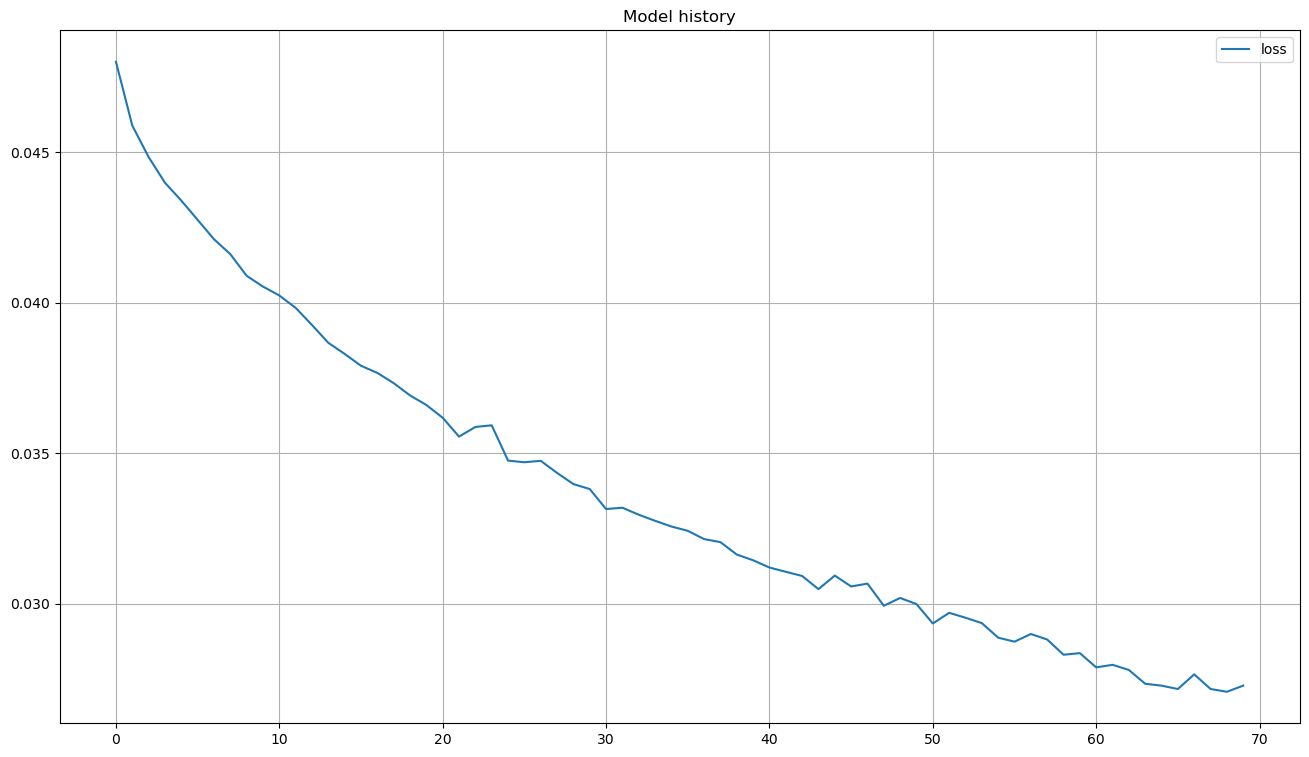

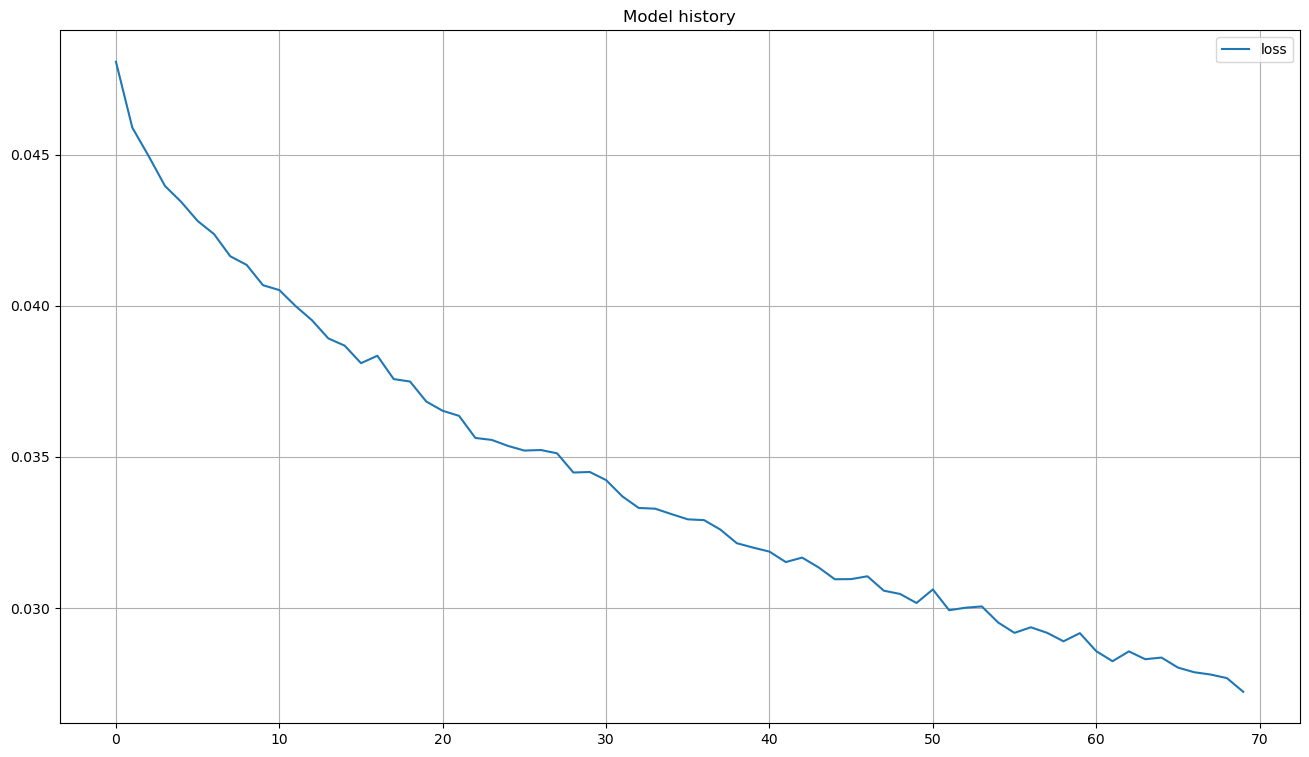

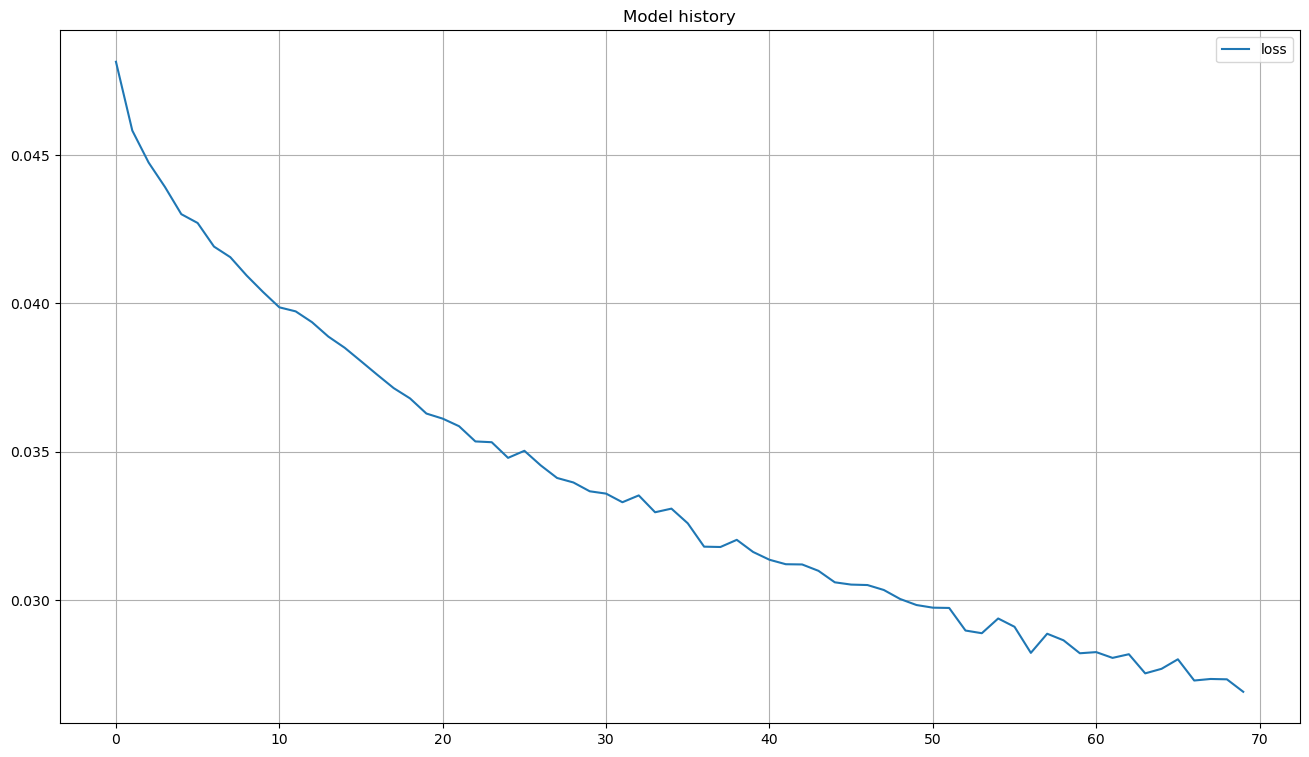

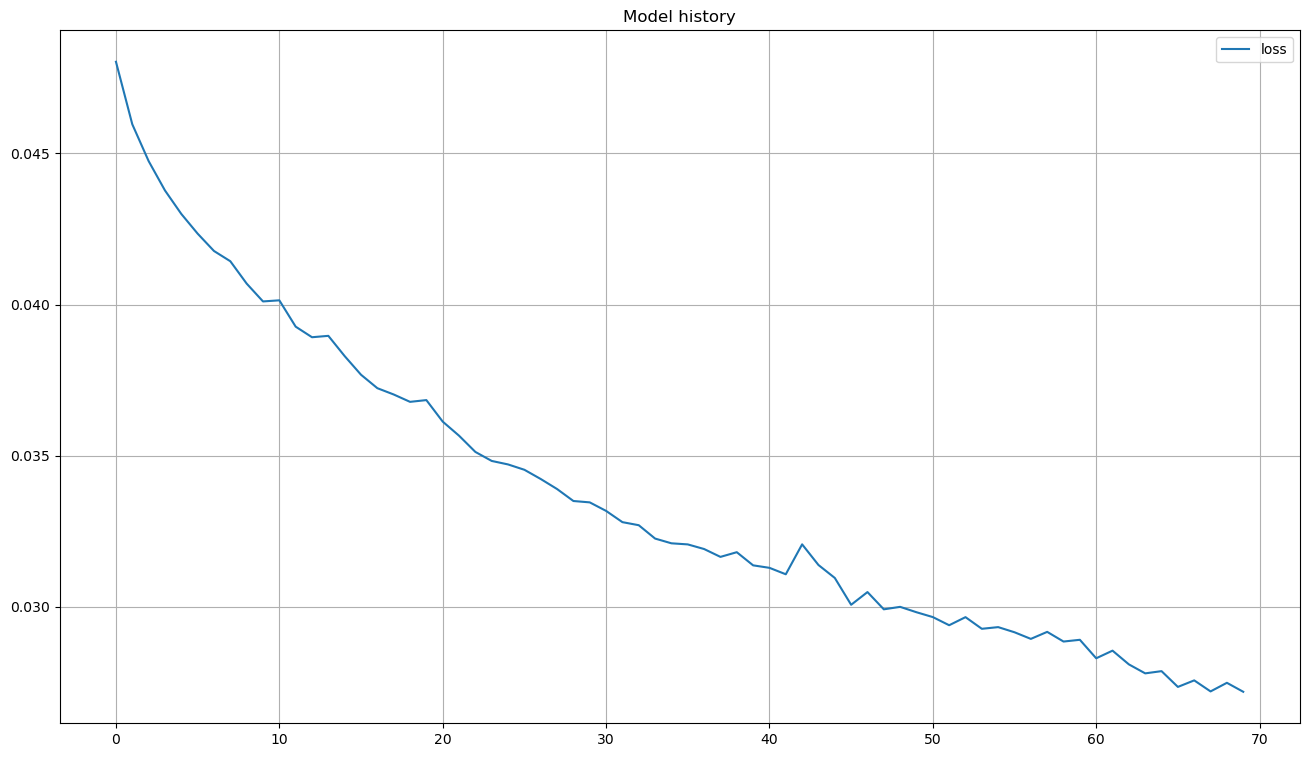

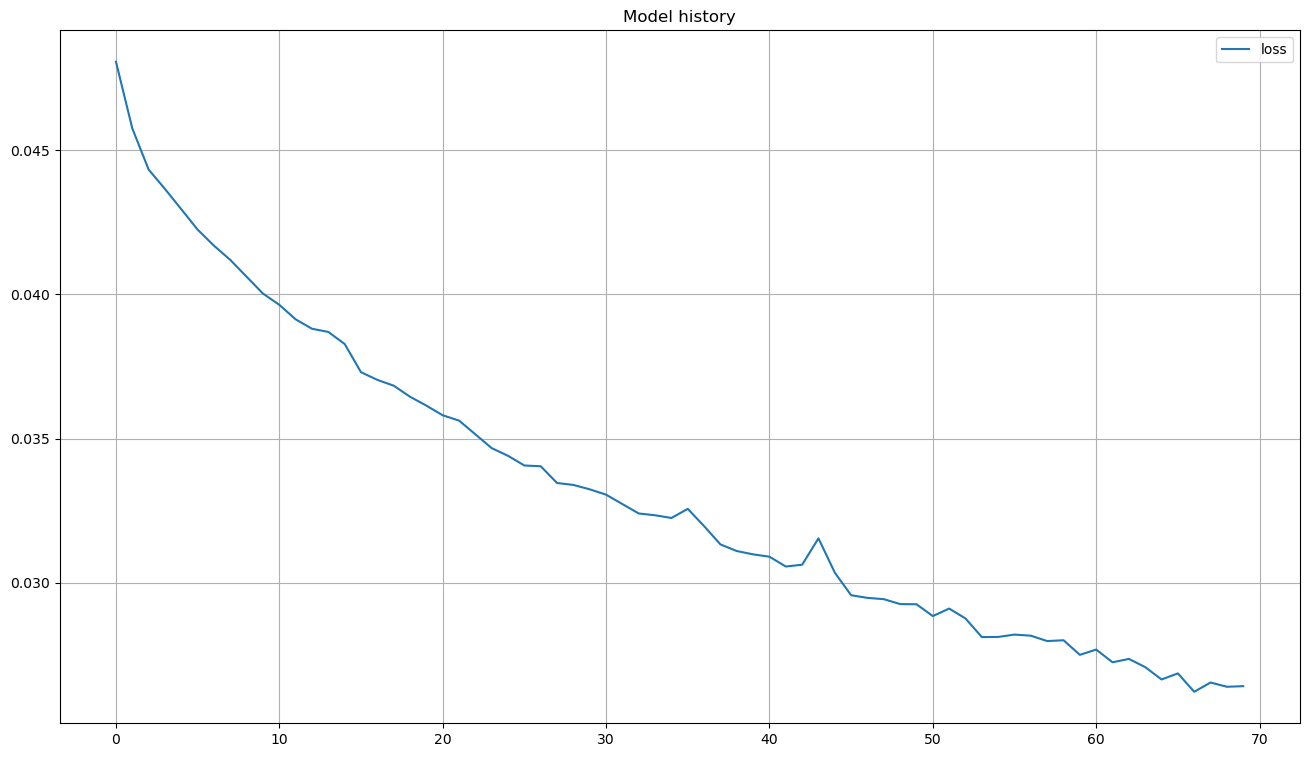

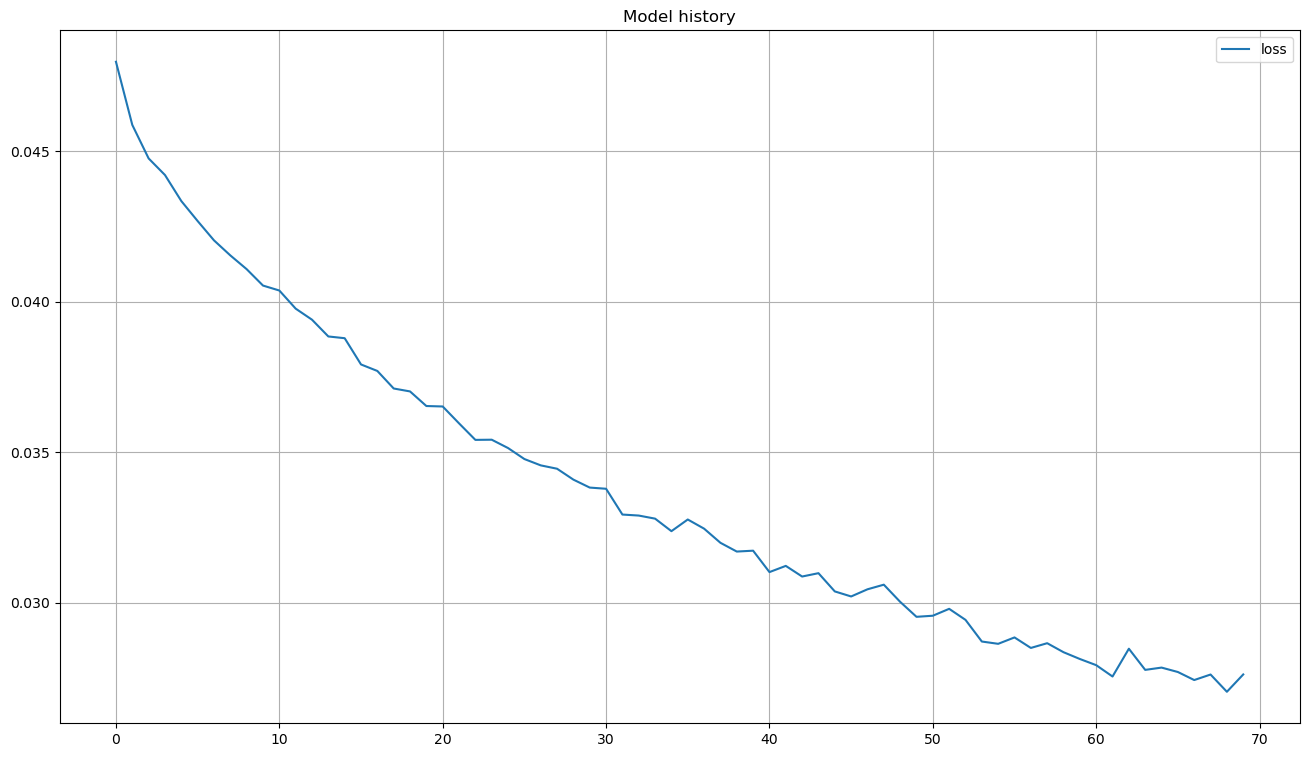

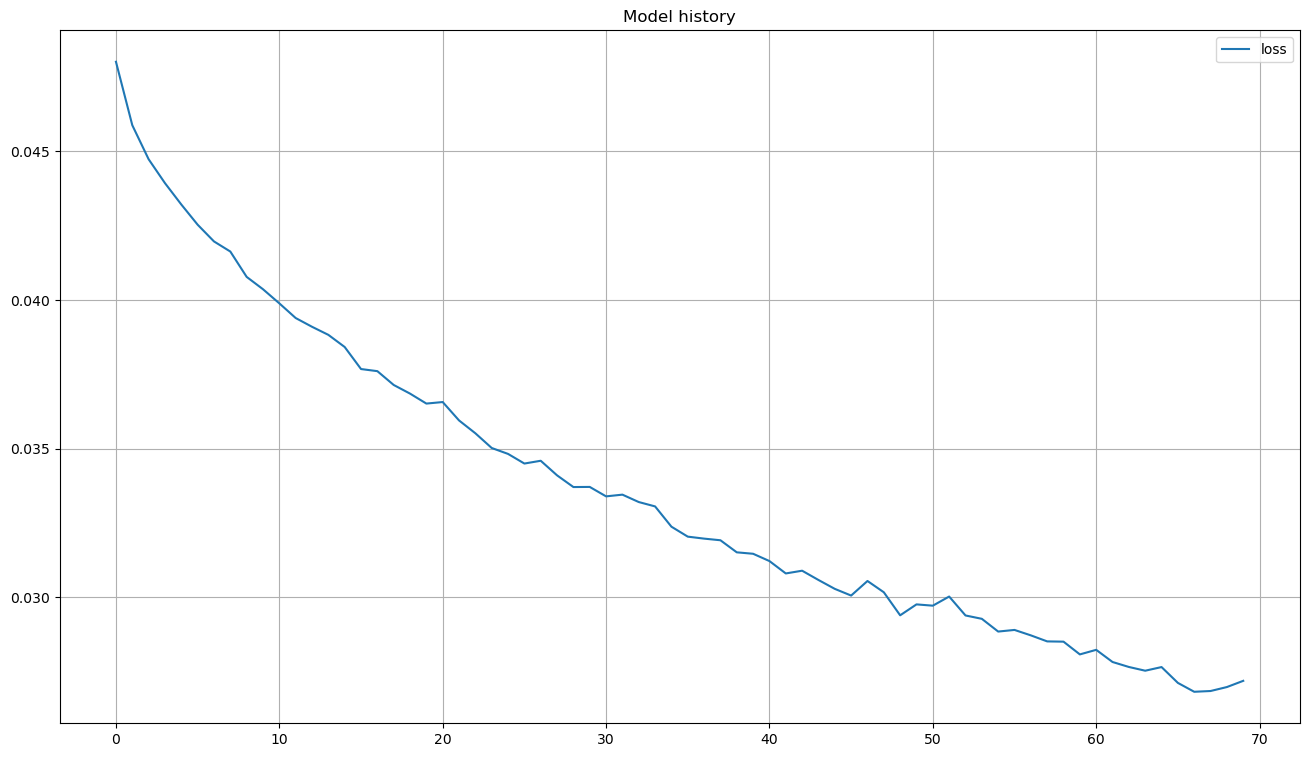

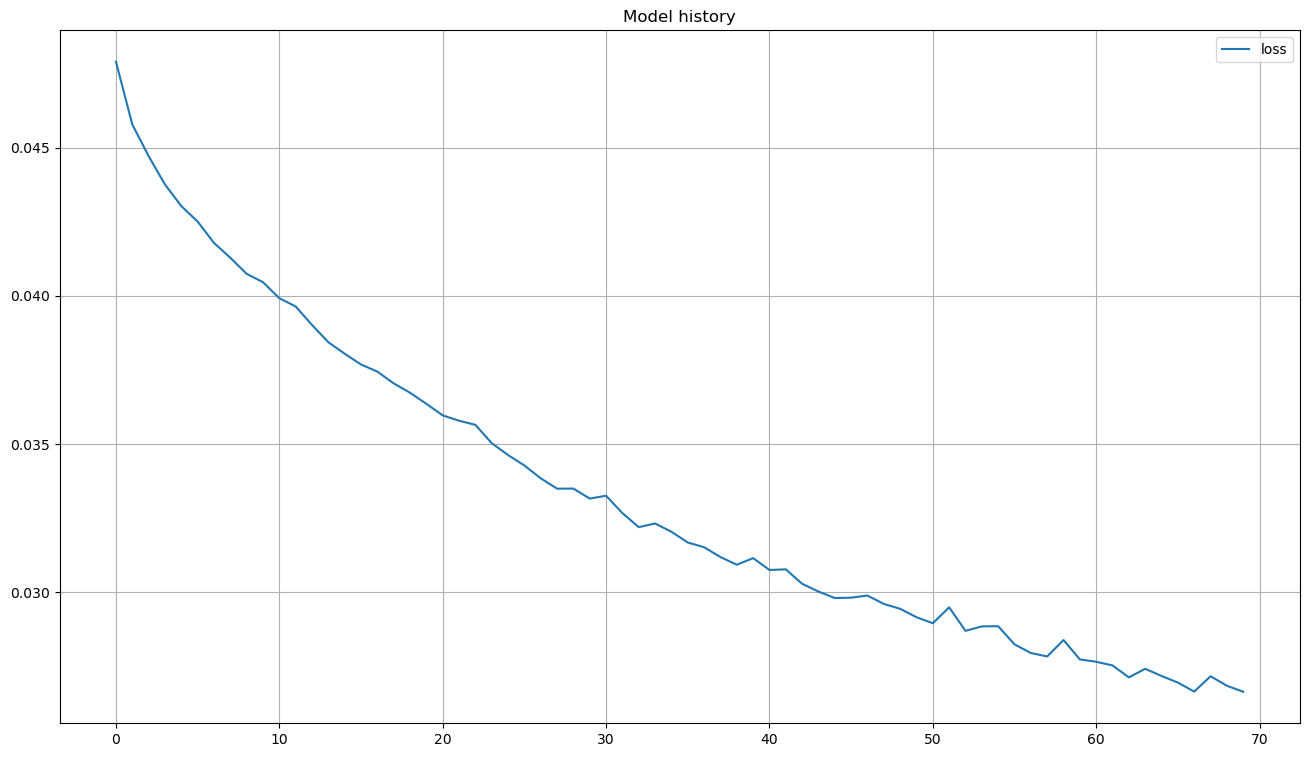

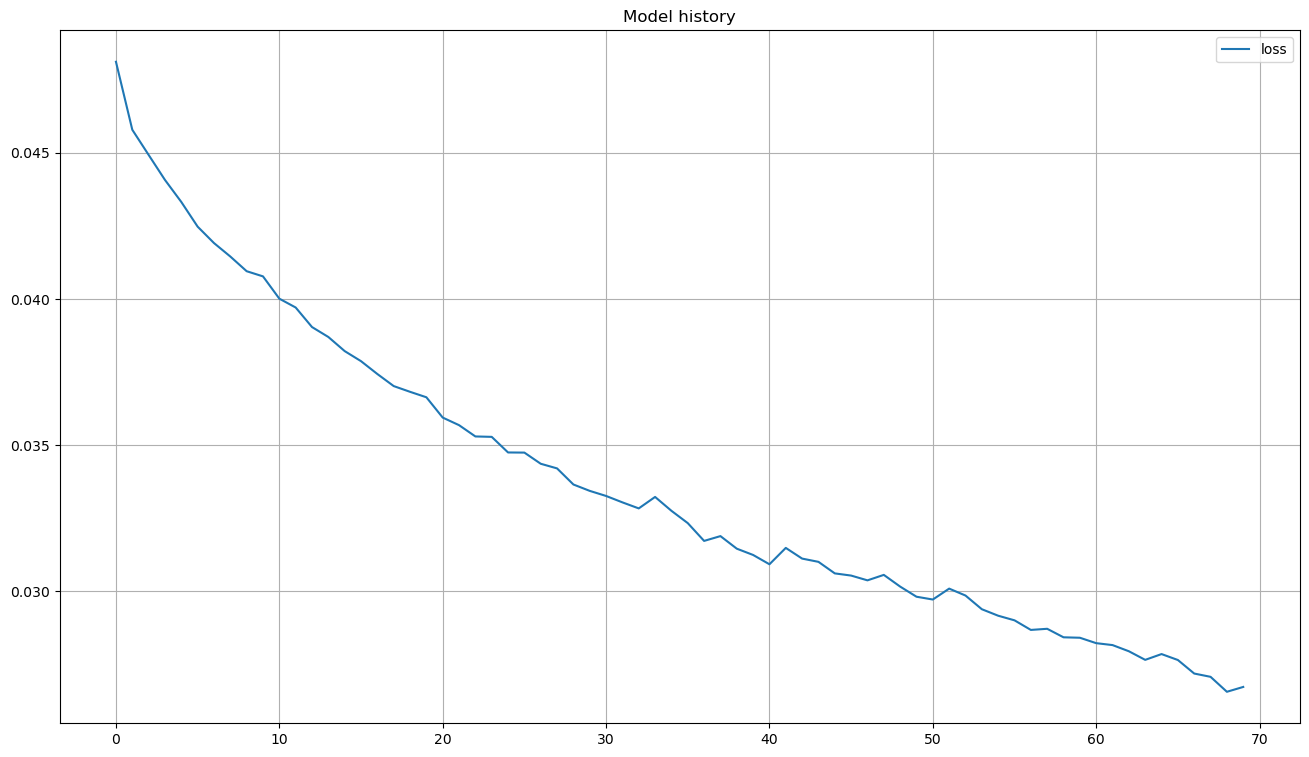

In [20]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
NUM_RUNS = 10

ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
N_EPOCHS = 70
#N_ANNOT = 59
K= N_CLASSES
AUC= np.zeros(NUM_RUNS)
res = np.zeros(NUM_RUNS)
BATCH_SIZE = 64


for i in range(NUM_RUNS):
   

    model = build_base_model()

    # add crowds layer on top of the base model
    model.add(CrowdsClassification(N_CLASSES, N_ANNOT, conn_type="MW"))


    # instantiate specialized masked loss to handle missing answers
    loss = MaskedMultiCrossEntropy().loss

    # compile model with masked loss and train
    model.compile(optimizer='adam', loss=loss)
    trainHistory =  model.fit(X, answers_bin_missings, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=0)

    # Create the history figure
    plt.figure(figsize=(16,9))
    for g in  trainHistory.history:
        plt.plot( trainHistory.history[g],label=g)
    plt.title('Model history')
    plt.legend()
    plt.grid()
    
     
    # remove crowds layer before making predictions
    model.pop() 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    Y_true_test1 = y_te

#     accuracy_test = eval_model(model, X_test, Y_true_test1)
#     print ("Accuracy: Test: %.3f" % (accuracy_test,) )
    
#     val_acc_metric = keras.metrics.CategoricalAccuracy()
#     for x_batch_val, y_batch_val in val_batches_MA:
#         val_logits = model(x_batch_val, training=False)
#         val_acc_metric.update_state(y_batch_val, val_logits)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     val_acc = val_acc.numpy()
#     print("Validation acc: %.4f" % (float(val_acc),))
    #res[i] =  accuracy_test 
    
    #AUC =======================
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
    val_logits = model(X_te, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test1, val_logits.numpy().argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    #AUC[i] = val_AUC
    val_AUC1 = roc_auc_score(ook(Y_true_test1),  val_logits[:,:N_CLASSES])
    print("Validation aUc_Sklearn: %.4f" % (float(val_AUC1),))
    AUC[i] = val_AUC1
    #===================================================
    
    report = classification_report(val_logits[:,:N_CLASSES].numpy().argmax(axis=1),Y_true_test1.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    
    
    print("Validation ACC: %.4f" % (float(ACC[i])))
    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test1.squeeze(), val_logits[:,:N_CLASSES].numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test1.squeeze(), val_logits[:,:N_CLASSES].numpy().argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test1.squeeze(), val_logits[:,:N_CLASSES].numpy().argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test1.squeeze(), val_logits[:,:N_CLASSES].numpy().argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))




In [21]:
import pickle

# create the dictionary with 6 scalar variables
Metrics = {
    'Accuracy': np.round(ACC.mean(),4)*100,
    'Accuracy_std': np.round(np.std( ACC),4)*100,
    'AUC': np.round( AUC.mean(),4)*100,
    'AUC_std': np.round(np.std( AUC),4)*100,
    'Balanced Accuracy': np.round( BACC.mean(),4)*100,
    'Balanced Accuracy_std':  np.round(np.std(BACC),4)*100,
    'MI': np.round( MI.mean(),4)*100,
    'MI_std': np.round(np.std(MI),4)*100,
    'Normalized MI': np.round( NMI.mean(),4)*100,
    'Normalized MI_std': np.round(np.std(NMI),4)*100,
    'Adjusted MI': np.round( AMI.mean(),4)*100,
    'Adjusted MI_std': np.round(np.std(NMI),4)*100,
}

# save the dictionary to a file using pickle
with open('data.pickle', 'wb') as handle:
    pickle.dump(Metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
Metrics

{'Accuracy': 60.809999999999995,
 'Accuracy_std': 1.59,
 'AUC': 89.42999999999999,
 'AUC_std': 0.7000000000000001,
 'Balanced Accuracy': 56.56,
 'Balanced Accuracy_std': 1.72,
 'MI': 97.92999999999999,
 'MI_std': 3.01,
 'Normalized MI': 43.09,
 'Normalized MI_std': 1.21,
 'Adjusted MI': 42.99,
 'Adjusted MI_std': 1.21}

In [23]:
print(classification_report(y_te,model.predict(X_te).argmax(axis=1).astype('float')))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.75      0.58      0.65      1005
           1       0.83      0.78      0.80       974
           2       0.53      0.43      0.47      1032
           3       0.41      0.33      0.37      1016
           4       0.46      0.73      0.56       999
           5       0.55      0.47      0.50       937
           6       0.59      0.84      0.69      1030
           7       0.76      0.59      0.66      1001
           8       0.76      0.73      0.74      1025
           9       0.76      0.81      0.78       981

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.62     10000
weighted avg       0.64      0.63      0.62     10000



In [24]:
 val_logits.numpy().argmax(axis=1).max()

9

## Ground truth Model

In [25]:
result_df = pd.concat([mean.rename('Mean'), std.rename('Std')], axis=1)

NameError: name 'mean' is not defined

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Save the DataFrame to an excel file
result_df.to_excel("Cifar10HGOLD.xlsx")

In [ ]:
result_df

## Multiple annotators

In [ ]:
# MA = MultipleAnnotators_Classification(K, R)
# def create_model():
#   base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(32, 32, 3),
#   )
#   base_model.trainable = False
#   inputs = keras.Input(shape=(32, 32, 3))
#   # x = keras.layers.Resizing(height=64,width=64,interpolation="bilinear")(inputs)
#   x = base_model(inputs)
#   x = keras.layers.Flatten()(x)
#   x = keras.layers.Dropout(0.5)(x)
#   x = keras.layers.Dense(256)(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.Dropout(0.5)(x)
#   output = MA.CrowdLayer(x)
#   model = keras.Model(inputs=inputs,outputs=output)
#   return model

In [ ]:
# NUM_RUNS = 1
# N_EPOCHS = 50
# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(K, R)
#   model = create_model()
#   model = MA.fit(model, train_batchesMA, N_EPOCHS)
#   val_acc[i] = MA.eval_model(test_batches)
#   print("Validation acc: %.4f" % (float(val_acc[i]),))